# Importar bibliotecas necessárias
Fazer o import e a instalação do necessário

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json

import numpy as np

# Abrir ficheiro de dados
Neste projeto todos os ficheiros de dados foram retirados de [dados.gov.pt](dados.gov.pt).

## Iniciar o processamento
Inicialmente temos apenas acesso à população em cada freguesia, no entanto, para fazer um estudo detalhado sobre a densidade na população de Portugal é necessário saber tambem o seu posicionamento geográfico.

Assim, neste primeiro passo, procuramos estabelecer uma correspondencia entre o codigo postal e a população presente em cada um. Fazemos isto por analisar o ficheiro **indica.json**

In [20]:
f = open("indica.json") 
data = json.load(f)

print(list(data[0]["Dados"]["2021"][0].keys()))

new_geocode = {}

for i in data[0]["Dados"]["2021"]:
    new_geocode[i["geocod"]] = i["valor"]


['geocod', 'geodsg', 'dim_3', 'dim_3_t', 'valor']


## Formato de cada Concelho

O formato de cada Concelho de Portugal encontra-se no ficheiro **concelhos-shapefile.zip**. 
Este contem a forma de todos os concelhos de Portugal, no entanto para este estudo não faz sentido considerar os arquipélagos da **Madeira** e **Açores**.

In [21]:
shapefile = gpd.read_file("concelhos-shapefile.zip")
np.array(list(shapefile.columns)).T

array(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2',
       'HASC_2', 'CCN_2', 'CCA_2', 'TYPE_2', 'ENGTYPE_2', 'NL_NAME_2',
       'VARNAME_2', 'geometry'], dtype='<U9')

Exclusão dos arquipélagos

In [22]:
shapefile["POP2021"] = shapefile['CCA_2'].map(new_geocode)
filtered_shapefile = shapefile[~shapefile['NAME_1'].isin(["Madeira","Azores"])]

filtered_shapefile.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,POP2021
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,NaN,NaN,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",28139
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,NaN,NaN,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",2578
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,NaN,NaN,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",3224
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,NaN,NaN,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",6428
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,NaN,NaN,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",12688


## Visualização da população por Concelho de Portugal Continental

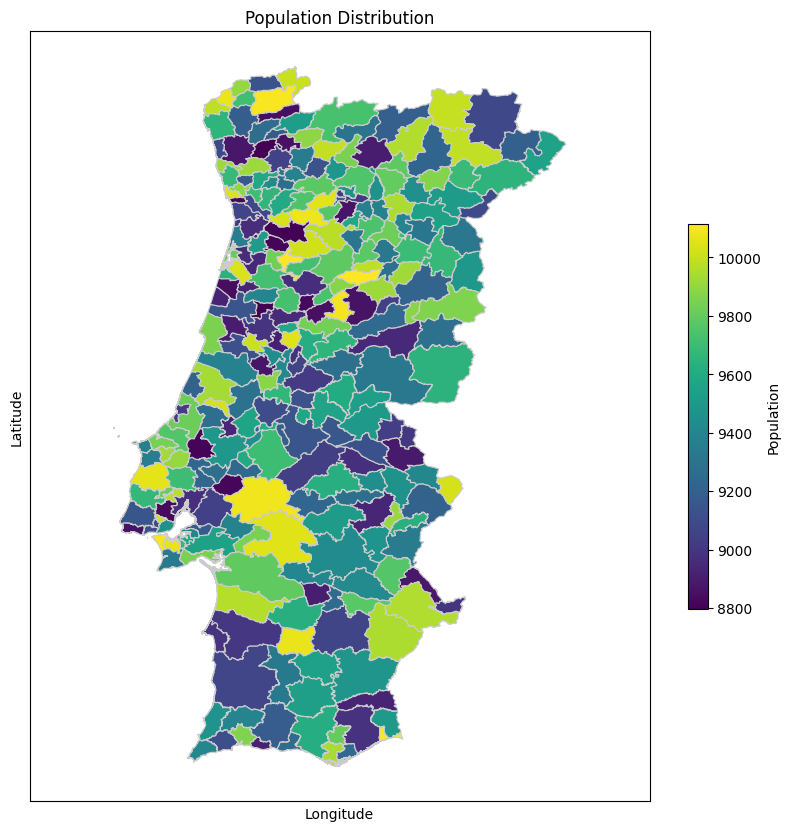

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot = filtered_shapefile.plot(column='POP2021', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Customize the plot
ax.set_title('Population Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=filtered_shapefile['POP2021'].min(), vmax=filtered_shapefile['POP2021'].max()))
sm._A = []  # This line is required to prevent matplotlib from complaining about the color mappable
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Population')



## Formato de cada Freguesia

O formato de cada Freguesia de Portugal encontra-se no ficheiro **cont-aad-caop2017.zip**. 

In [24]:
freg_shape = gpd.read_file("cont-aad-caop2017.zip").to_crs(epsg=4326)

In [25]:
freg_shape.columns

Index(['Dicofre', 'Freguesia', 'Concelho', 'Distrito', 'TAA', 'AREA_EA_Ha',
       'AREA_T_Ha', 'Des_Simpli', 'geometry'],
      dtype='object')

Seleção de concelhos que fazem parte da capital de Distrito.

In [26]:
freg_shape["POP2021"] = freg_shape['Dicofre'].map(new_geocode)

filtered_freg = filtered_shapefile[filtered_shapefile['NAME_1'] == filtered_shapefile['NAME_2']]

## Visualização da população por Concelho de Portugal Continental com capitais de distrito

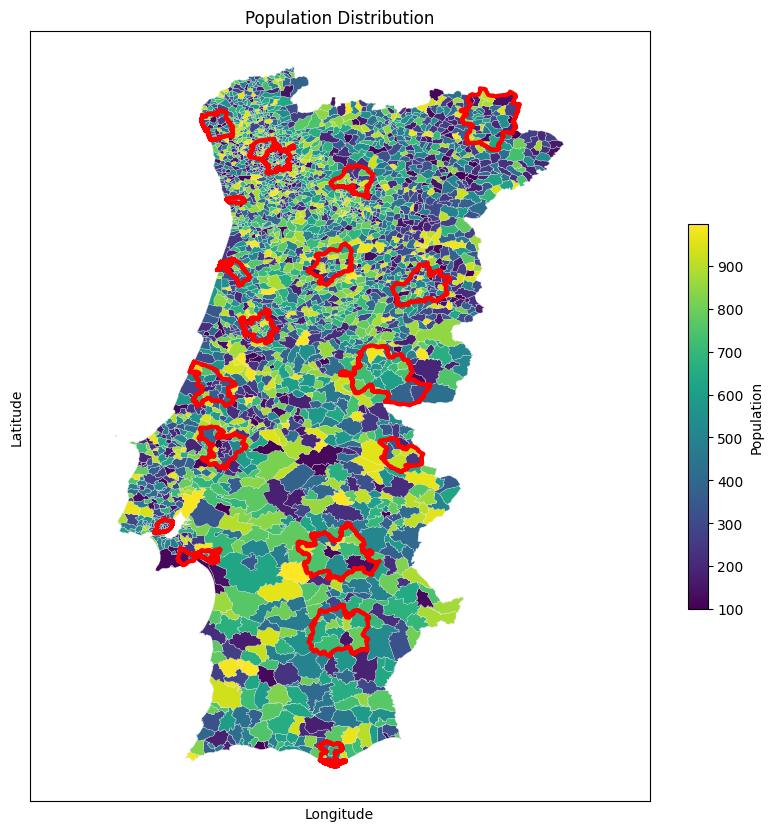

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot = freg_shape.plot(column='POP2021', cmap='viridis', linewidth=0.2, ax=ax, edgecolor='0.9', legend=False)

# Customize edge color for shapes with 'red' color_code
red_shapes = filtered_freg
red_shapes.boundary.plot(ax=ax, edgecolor='red', linewidth=3)


# Customize the plot
ax.set_title('Population Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=freg_shape['POP2021'].min(), vmax=freg_shape['POP2021'].max()))
sm._A = []  # This line is required to prevent matplotlib from complaining about the color mappable
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Population')

Calcula-se a Densidade Populacional pela formula:
$$ \text{POPDEN} = \dfrac{\text{Populacao}}{\text{Area da Freguesia}} $$

É feita tambem a normalização da Densidade Populacional, com a seguinte formula:
$$ \text{POPDEN NORM} = \dfrac{\text{POPDEN} - \min(POPDEN)}{\max(POPDEN) - \min(POPDEN)}$$

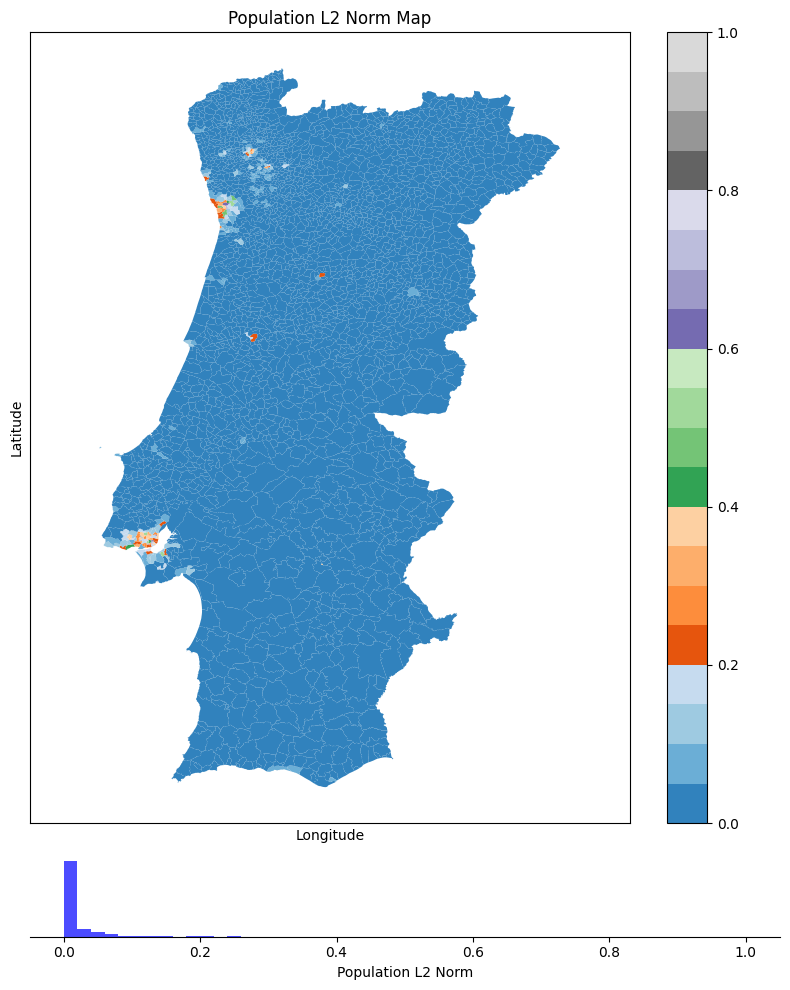

In [28]:
freg_shape['POPDEN'] = freg_shape['POP2021'].astype(float)/freg_shape['AREA_T_Ha'].astype(float)

min_value = freg_shape['POPDEN'].min()
max_value = freg_shape['POPDEN'].max()

freg_shape['POPDEN_NORM'] = (freg_shape['POPDEN'] - min_value) / (max_value - min_value)

# Plot the population density graph
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 10), gridspec_kw={'height_ratios': [10, 1]})
freg_shape.plot(column='POPDEN_NORM', cmap='tab20c', legend=True, ax=ax1)
ax1.set_title('Population L2 Norm Map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot a histogram on the right subplot
ax2.hist(freg_shape['POPDEN_NORM'], bins=50, color='blue', alpha=0.7)
ax2.set_xlabel('Population L2 Norm')
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)  # Remove top border
ax2.spines['right'].set_visible(False)  # Remove right border
ax2.spines['left'].set_visible(False)  # Remove left border

plt.tight_layout()
plt.show()



## Ajuste dos dados
Como a representação dos dados não era satisfatória foi necessário aplicar aos dados uma transformação, onde se aplicou a seguinte formula:

$$ \text(POPDEN NORM) = \sqrt(\sqrt(\text(POPDEN NORM))) $$

Aplicou-se então a raiz quadrada, duas vezes, para que houvesse um ajuste dos valores concentrados entre o valor $0.0$ e $0.2$, podemos ver a modelação da formula na seguinte imagem: 
<p align="center" width="100%">
    <img width="50%" src="sqrtsqrt.png"> 
</p>

In [29]:
freg_shape['POPDEN_NORM'] = np.sqrt(np.sqrt(freg_shape['POPDEN_NORM'])) # operation to see data disparity

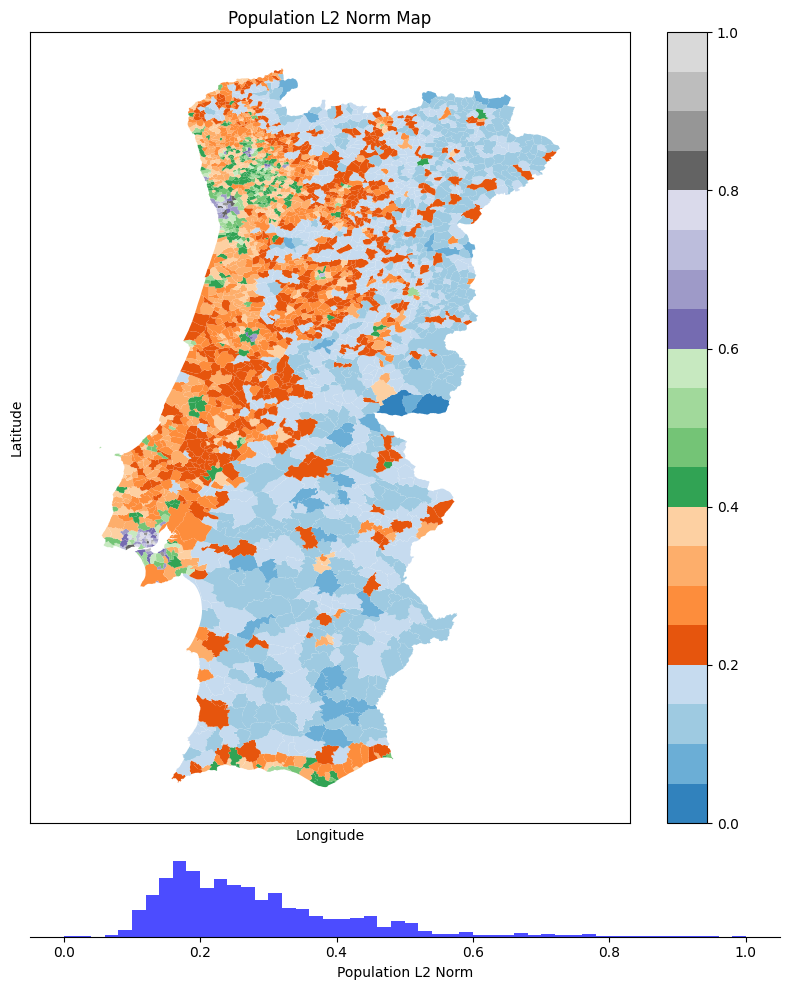

In [30]:

# Plot the population density graph
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 10), gridspec_kw={'height_ratios': [10, 1]})
freg_shape.plot(column='POPDEN_NORM', cmap='tab20c', legend=True, ax=ax1)
ax1.set_title('Population L2 Norm Map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot a histogram on the right subplot
ax2.hist(freg_shape['POPDEN_NORM'], bins=50, color='blue', alpha=0.7)
ax2.set_xlabel('Population L2 Norm')
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)  # Remove top border
ax2.spines['right'].set_visible(False)  # Remove right border
ax2.spines['left'].set_visible(False)  # Remove left border

plt.tight_layout()
plt.show()

## Estudo sobre como a densidade influencia a dinamização do terrotório
A dinamização do território deverá ser implementada segundo a densidade da população, fazendo com que o maior numero de pessoas consiga tirar proveito do investimento.

Por este estudo, é preceptivel uma densidade de população perto de àreas metropolitanas como Lisboa, Porto e tambem Algarve, mas este com menor densidade. Podemos tentar perceber agora quais as àreas mais susceptiveis a mudanças nos próximos anos, sendo que estas vão estar perto das zonas de maior densidade, afentando preços de habitação, tempo de deslocamento, etc.

In [31]:
from scipy.stats import gaussian_kde
gdf = freg_shape.to_crs(epsg=4326)

# Extract coordinates and population density from the GeoDataFrame
x = gdf.geometry.centroid.x
y = gdf.geometry.centroid.y
population_density = np.sqrt(gdf['POPDEN_NORM'])

# Perform Kernel Density Estimation (KDE) on the points
kde = gaussian_kde(np.vstack((x, y)), weights=population_density,bw_method=0.1)

# Generate a grid of points for the density lines
space = 250
grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), space), np.linspace(y.min(), y.max(), space))
grid_z = kde(np.array([grid_x.flatten(), grid_y.flatten()]))


/var/folders/9c/xd86ry_d2699hb0m1xykv0yc0000gn/T/ipykernel_16887/1493912959.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = gdf.geometry.centroid.x
/var/folders/9c/xd86ry_d2699hb0m1xykv0yc0000gn/T/ipykernel_16887/1493912959.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = gdf.geometry.centroid.y


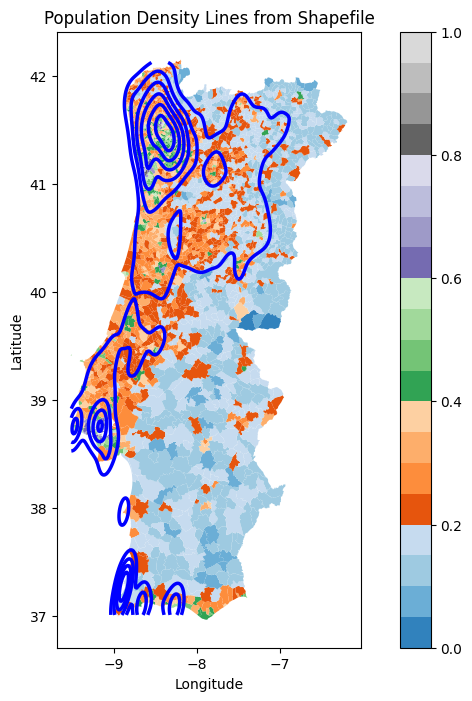

In [32]:
# Create density lines
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
freg_shape.plot(column='POPDEN_NORM', cmap='tab20c', legend=True, ax=ax)
ax1.set_title('Population L2 Norm Map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])

density_lines = ax.contour(grid_x, grid_y, grid_z.reshape(grid_x.shape), colors='blue', linewidths=2.5)

# Set plot title and labels
ax.set_title('Population Density Lines from Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

/var/folders/9c/xd86ry_d2699hb0m1xykv0yc0000gn/T/ipykernel_16887/2652371249.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = gdf.geometry.centroid.x
/var/folders/9c/xd86ry_d2699hb0m1xykv0yc0000gn/T/ipykernel_16887/2652371249.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = gdf.geometry.centroid.y


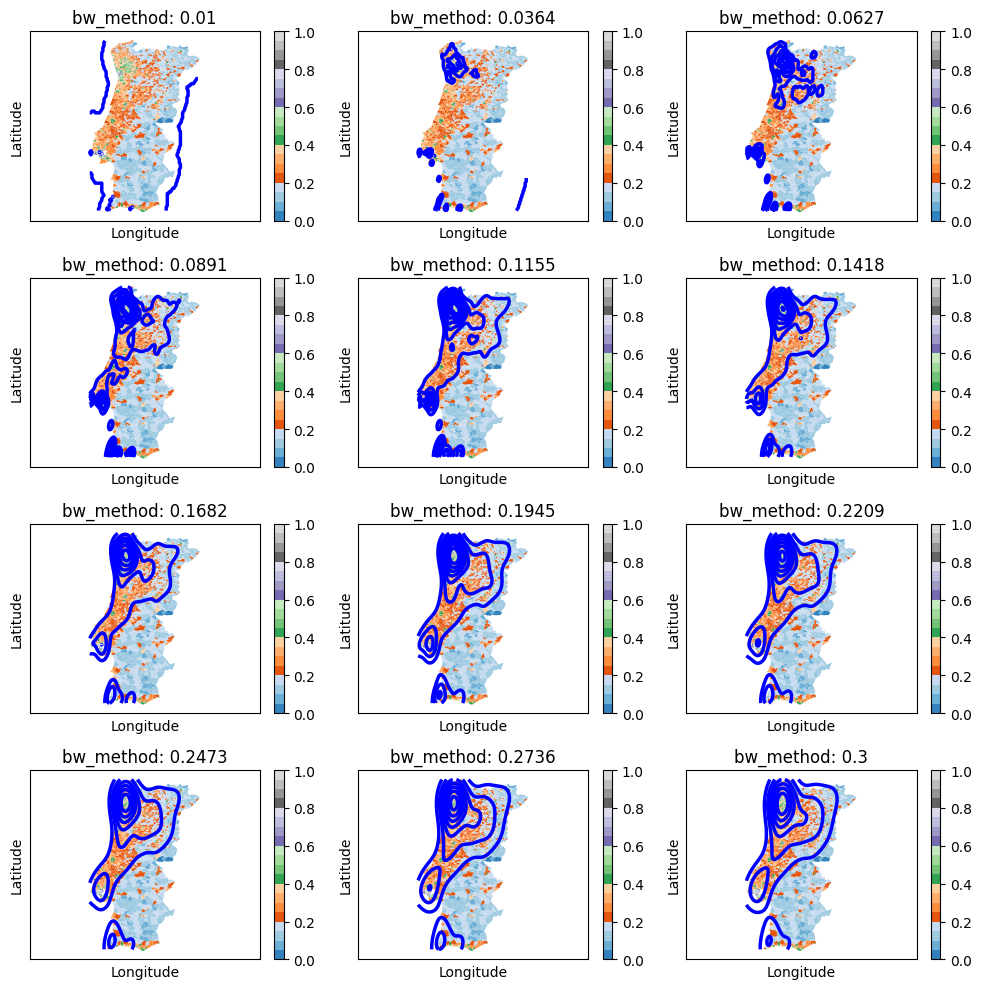

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example list of values
values = np.linspace(0.01,0.3,12)
gdf = freg_shape.to_crs(epsg=4326)

# Extract coordinates and population density from the GeoDataFrame
x = gdf.geometry.centroid.x
y = gdf.geometry.centroid.y
population_density = np.sqrt(gdf['POPDEN_NORM'])

# Calculate the number of subplots based on the length of the values list
n = len(values)

# Calculate the number of rows and columns for the subplot grid
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

# Create a grid of subplots
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))

# Generate example data and plot for each value
for i, value in enumerate(values):
    row = i // cols
    col = i % cols
    # Perform Kernel Density Estimation (KDE) on the points
    kde = gaussian_kde(np.vstack((x, y)), weights=population_density, bw_method=value)

    # Generate a grid of points for the density lines
    space = 100
    grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), space), np.linspace(y.min(), y.max(), space))
    grid_z = kde(np.array([grid_x.flatten(), grid_y.flatten()]))

    freg_shape.plot(column='POPDEN_NORM', cmap='tab20c', legend=True, ax=axs[row, col])
    axs[row, col].set_title('Population L2 Norm Map')
    axs[row, col].set_xlabel('Longitude')
    axs[row, col].set_ylabel('Latitude')
    axs[row, col].axis('equal')
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])

    density_lines = axs[row, col].contour(grid_x, grid_y, grid_z.reshape(grid_x.shape), colors='blue', linewidths=2.5)

    # Set plot title and labels
    axs[row, col].set_title('Population Density Lines from Shapefile')
    axs[row, col].set_xlabel('Longitude')
    axs[row, col].set_ylabel('Latitude')

    axs[row, col].set_title(f'bw_method: {np.round(value,4)}')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()
